In [154]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [155]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [156]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [157]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [158]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [159]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/work/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [160]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [161]:
stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [162]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [163]:
stopword_ru[200:210]

['ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам']

In [164]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [165]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

/Users/work/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 27000/27000 [00:30<00:00, 896.91it/s] 

CPU times: user 28.9 s, sys: 541 ms, total: 29.4 s
Wall time: 30.1 s


In [166]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [04:16<00:00, 105.21it/s]

CPU times: user 4min 9s, sys: 3.09 s, total: 4min 12s
Wall time: 4min 16s


In [167]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [168]:
N_topic = 20

In [169]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 53.7 s, sys: 419 ms, total: 54.1 s
Wall time: 35.2 s


In [170]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [171]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [172]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [173]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 43.8 s, sys: 191 ms, total: 44 s
Wall time: 27.2 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.056009,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.50434,0.0,0.0,0.000000,0.154566,0.000000,0.154423,0.0,0.0,0.000000
1,4896,0.000000,0.0,0.000000,0.472458,0.240836,0.0,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.264326,0.000000,0.0,0.0,0.000000
2,4897,0.162906,0.0,0.000000,0.812697,0.000000,0.0,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,4898,0.380965,0.0,0.079888,0.132966,0.000000,0.0,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.202992
4,4899,0.000000,0.0,0.149446,0.068481,0.000000,0.0,0.0,0.229692,0.0,...,0.00000,0.0,0.0,0.136683,0.000000,0.134522,0.000000,0.0,0.0,0.000000


In [174]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [175]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  
    return user_vector

In [176]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.        , 0.        , 0.        , 0.        , 0.00907416,
       0.01692424, 0.        , 0.21555891, 0.        , 0.01599354,
       0.00757682, 0.        , 0.        , 0.        , 0.00577723,
       0.        , 0.06740984, 0.03693813, 0.        , 0.03291432])

In [177]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 705 ms, sys: 12.9 ms, total: 718 ms
Wall time: 732 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.033763,0.030317,0.0,0.000000,0.053350,0.028043,0.263487,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.057397,0.000000,0.000000
1,u108690,0.103012,0.005262,0.000000,0.0,0.074330,0.039031,0.037496,0.334121,0.0,...,0.042538,0.010047,0.000000,0.0,0.038153,0.000000,0.000000,0.021732,0.005206,0.093257
2,u108339,0.000000,0.000000,0.035776,0.0,0.136312,0.048698,0.022949,0.179799,0.0,...,0.031138,0.028328,0.049635,0.0,0.022761,0.008325,0.020757,0.160078,0.000000,0.050605


In [178]:
target = pd.read_csv("users_churn.csv")

In [179]:
X = pd.merge(user_embeddings, target, 'left')

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [181]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [182]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [183]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05593124, 0.06047084, 0.36371824, 0.12316489, 0.05336107,
       0.01660725, 0.03706196, 0.01316771, 0.12589742, 0.04998888])

In [184]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

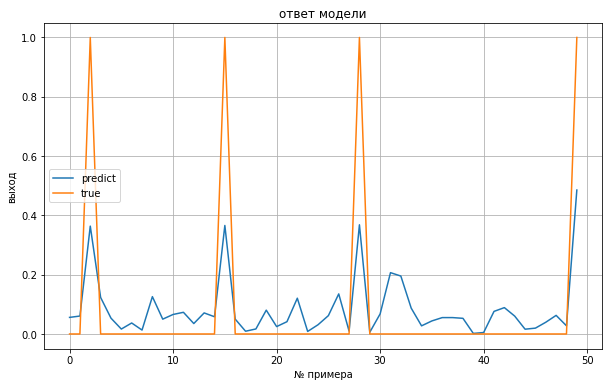

In [185]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [186]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.26204460208342095, F-Score=0.782, Precision=0.710, Recall=0.869


In [187]:
roc = roc_auc_score(y_test, preds)
roc

0.9775917204488632

In [188]:
result = pd.DataFrame(columns = ['model', 'F-Score', 'Precision' 'Recall', 'roc_auc_score'] )
result

,model,F-Score,PrecisionRecall,roc_auc_score


In [189]:
result = result.append({
    'model' : 'median',
    'F-Score' : fscore[ix],
    'Precision' : precision[ix],
    'Recall' : recall[ix],
    'roc_auc_score' : roc
}, ignore_index=True)

Повторить п.2, но используя уже не медиану, а max

In [190]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  
    return user_vector

In [191]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.27308172, 0.04869375, 0.04518698, 0.        , 0.10751005,
       0.19260344, 0.13828962, 0.44706285, 0.02803504, 0.21681598,
       0.0941259 , 0.02593151, 0.18932141, 0.06598034, 0.31606495,
       0.1977548 , 0.24464892, 0.42730865, 0.07350872, 0.17192532])

In [192]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 307 ms, sys: 10.4 ms, total: 317 ms
Wall time: 320 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.136633,0.206671,0.284376,0.143980,0.251335,0.178089,0.248518,0.693135,0.098383,...,0.164287,0.163319,0.027129,0.000000,0.043309,0.064942,0.242971,0.123107,0.070041,0.056981
1,u108690,0.174570,0.026817,0.019807,0.010015,0.275148,0.149219,0.168928,0.376731,0.046493,...,0.201715,0.053263,0.079458,0.024264,0.317241,0.023371,0.143959,0.168212,0.038925,0.289597
2,u108339,0.145668,0.116677,0.087130,0.074546,0.262372,0.236142,0.056643,0.221311,0.055505,...,0.069123,0.075429,0.199570,0.013219,0.090950,0.094440,0.062767,0.316519,0.012533,0.110200


In [193]:
X = pd.merge(user_embeddings, target, 'left')

In [194]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [195]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [196]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1245966 , 0.00580975, 0.59950572, 0.1287842 , 0.04149806,
       0.00301402, 0.05491968, 0.02182549, 0.10593542, 0.09528685])

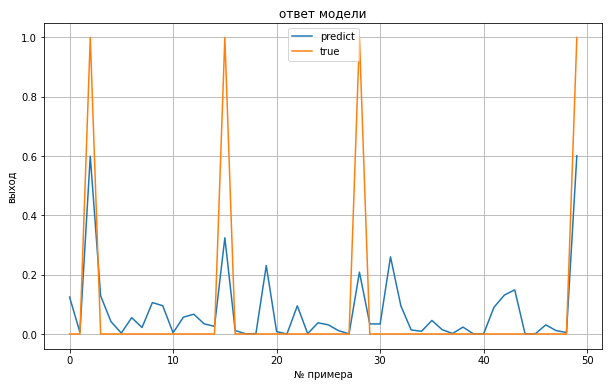

In [197]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [198]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.2756613631549777, F-Score=0.756, Precision=0.674, Recall=0.861


In [199]:
roc_max = roc_auc_score(y_test, preds)
roc_max

0.9687586487586487

In [200]:
result = result.append({
    'model' : 'max',
    'F-Score' : fscore[ix],
    'Precision' : precision[ix],
    'Recall' : recall[ix],
    'roc_auc_score' : roc_max
}, ignore_index=True)

In [201]:
result

,model,F-Score,PrecisionRecall,roc_auc_score,Precision,Recall
0,median,0.781651,NaN,0.977592,0.710000,0.869388
1,max,0.756272,NaN,0.968759,0.674121,0.861224



*Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)

In [202]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [203]:
tf = TfidfVectorizer(stop_words=stopword_ru, max_features=N_topic )

In [204]:
tf.fit(news['title'])

/Users/work/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['_ссылка', 'всё', 'интерфакс', 'как_сообщили_риа_', 'новости', 'передает_риа_', 'сообщает_', 'сообщает_риа_'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


AttributeError: 'list' object has no attribute 'lower'

In [ ]:
x0 = tf.transform(news['title'])

In [ ]:
x0

In [ ]:
news_idf = pd.DataFrame(x0, columns=["idf_weights"]) 

In [ ]:
news_idf.describe()